In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import time
import sys
# sys.path.insert(0, '/home/farnoush/symbolicXAI/')
import numpy as np
from symbxai.lrp.symbolic_xai import ViTSymbolicXAI
from symbxai.model.vision_transformer import ModifiedViTForImageClassification
import matplotlib.pylab as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
import transformers
import torchvision
import requests
from PIL import Image
from io import BytesIO
# from lang_sam import LangSAM
import pickle
import itertools
import torch
from torchvision.transforms.functional import crop
from torchvision.ops import box_iou
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

/opt/homebrew/Caskroom/miniconda/base/envs/symbxai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Extract eyes, mouth

In [4]:
with open('../data/eyes_segments.json', 'rb') as f:
    eyes_file = pickle.load(f)

# with open('/home/farnoush/eyebrows_segments.json', 'rb') as f:
#     eyebrows_file = pickle.load(f)

with open('../data/mouth_segments.json', 'rb') as f:
    mouth_file = pickle.load(f)

In [ ]:
def filter_boxes(boxes, masks, logits, part='eyes'):
    """
    Filter extracted bounding boxes based on their confidence scores and some other criteria.
    """
    # boxes is actaually not used here
    num = 0
    if part == 'eyes':
        num = 2
    elif part == 'mouth':
        num = 1
    elif part == 'eyebrows':
        num = 2

    # If the mask is covering more than half of the image, remove it.
    for i in range(len(logits)):
        score = masks[i].sum() / (224 * 224)
        if score > 0.5:
            logits[i] = 0

    indices = logits.argsort()[::-1]
    values = logits[indices]
    indices = indices[values != 0]
    
    if len(logits) > num:
        indices = indices[:num]

    return indices


def split_image_into_patches(image, patch_size):
    """
    Split an image into patches of a given size.
    Note at July 3rd 2024: The image input is actally not necessary. Also the output of this
    function is not the patches itself, but the indices bounding boxes of each patch. And this
    output is not necessary to be computed for each image since it's always the same.
    """
    # Get the dimensions of the image.
    image_width, image_height = image.size

    # Define the patch size.
    patch_width, patch_height = patch_size

    # Initialize a list to store patch bounding boxes.
    patch_bounding_boxes = []

    # Loop through the image and extract patches.
    for y in range(0, image_height, patch_height):
        for x in range(0, image_width, patch_width):
            # Define the bounding box coordinates.
            left = x
            upper = y
            right = x + patch_width
            lower = y + patch_height

            # Append the bounding box to the list.
            patch_bounding_boxes.append((left, upper, right, lower))

            # Extract the patch.
            # patch = image.crop((left, upper, right, lower)) # This is never returned

    return patch_bounding_boxes

def find_intersecting_patches(box, patches):
    """
    Check if there is an intersection between a bounding box and a patch.
    """
    # Convert box and patches to tensor
    box_tensor = torch.tensor([box], dtype=torch.float32)
    patches_tensor = torch.tensor(patches, dtype=torch.float32)

    # Calculate IoU (Intersection over Union) between the box and patches
    iou = box_iou(box_tensor, patches_tensor)

    # Find indices where IoU is non-zero (indicating intersection)
    intersecting_indices = torch.nonzero(iou.squeeze() > 0).squeeze().tolist()

    return intersecting_indices

In [ ]:
# Filter those boxes that are reasonably detected.
boxes_eyes = []
for dic in tqdm(eyes_file):
    indices = filter_boxes(boxes=dic['boxes_eyes'], masks=dic['mask_eyes'], logits=dic['logits_eyes'], part='eyes')
    # if indices is not None:
    boxes_eyes.append(np.expand_dims(dic['boxes_eyes'][indices], axis=0))
    # else:
    #     assert False, 'This actually never happens'
    #     boxes_eyes.append(dic['boxes_eyes'][indices])

boxes_mouth = []
for dic in tqdm(mouth_file):
    indices = filter_boxes(dic['boxes_mouth'], dic['mask_mouth'], dic['logits_mouth'], 'mouth')
    # if indices is not None:
    boxes_mouth.append(np.expand_dims(dic['boxes_mouth'][indices], axis=0))
    # else:
    #     assert False, 'This actually never happens'
    #     boxes_mouth.append(dic['boxes_mouth'][indices])

# boxes_eyebrows = []
# for dic in tqdm(eyebrows_file):
#     indices = filter_boxes(dic['boxes_eyebrows'], dic['mask_eyebrows'], dic['logits_eyebrows'], 'eyebrows')
#     if indices is not None:
#        boxes_eyebrows.append(np.expand_dims(dic['boxes_eyebrows'][indices], axis=0)) 
#     else:
#         boxes_eyebrows.append(dic['boxes_eyebrows'][indices])

100%|██████████| 280/280 [00:00<00:00, 36654.34it/s]


In [ ]:
# import re
# from symbxai.dataset.utils import load_fer_dataset

crop_size = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

size = int((256 / 224) * crop_size)
segmentation_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=size),
    torchvision.transforms.CenterCrop(crop_size),
])

patch_size = 16
image_patches = []
for dic in tqdm(eyes_file):
    path = dic['image'].replace('/home/farnoush/symbolicXAI/dataset/images/', 
                                '/Users/thomasschnake/Research/Projects/symbolic_xai/datasets/fer_images/')
    image_pil = Image.open(path).convert("RGB")
    sample = segmentation_transforms(image_pil)
    patches = split_image_into_patches(sample, (16, 16))
    image_patches.append(patches) # thise are just he bounding boxes for each patch, not the patch itself.



100%|██████████| 280/280 [00:00<00:00, 1284.60it/s]


In [ ]:
# 
eyes_indices = []
mouth_indices = []
# eyebrows_indices = []

for i in tqdm(range(280)):
    eyes = []
    for box in boxes_eyes[i][0]:
        eyes.append(find_intersecting_patches(box, image_patches[i]))
    eyes_indices.append(eyes)

    # eyebrows = []
    # for box in boxes_eyebrows[i][0]:
    #     eyebrows.extend(find_intersecting_patches(box, image_patches[i]))
    # eyebrows_indices.append(eyebrows)

    mouth = []
    for box in boxes_mouth[i][0]:
        mouth.append(find_intersecting_patches(box, image_patches[i]))
    mouth_indices.append(mouth)

  0%|          | 0/280 [00:00<?, ?it/s]

/var/folders/wh/dzlv3bps3ms61gjh0rl9y1r00000gp/T/ipykernel_20462/462574233.py:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  box_tensor = torch.tensor([box], dtype=torch.float32)
100%|██████████| 280/280 [00:00<00:00, 3861.96it/s]


After a thorough visual insepction, these images were found to be problematic.

In [ ]:
problematic_images = [
    12,
    15,
    16,
    17,
    24,
    253,
    260,
    263,
    279,
    3,
    4,
    5,
    9,
    13,
    252
]

## Use Symbolic XAI framework

In [ ]:
crop_size = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

size = int((256 / 224) * crop_size)
size = 224

label_to_id = {'sad': 0, 'disgust': 1, 'angry': 2, 'neutral': 3, 'fear': 4, 'surprise': 5, 'happy': 6}

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=size, interpolation=3),
    torchvision.transforms.CenterCrop(crop_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

### Load model

In [ ]:
processor = transformers.AutoImageProcessor.from_pretrained("dima806/facial_emotions_image_detection")
model = transformers.AutoModelForImageClassification.from_pretrained("dima806/facial_emotions_image_detection")
model.eval()

model.vit.embeddings.patch_embeddings.requires_grad = False
model.vit.embeddings.patch_embeddings.requires_grad = False

for name, param in model.named_parameters():
    if name.endswith('embed'):
        param.requires_grad = False

pretrained_embeddings = model.vit.embeddings

In [ ]:
def generate_table(tokens, max_subsetsize = 4):
    N = len(tokens)
    # num_subsets = 2 ** N

    # Generate all subsets of tokens
    subsets = list(itertools.chain.from_iterable(itertools.combinations(tokens, r) for r in range(N+1)))
    subsets = [sset for sset in subsets if sset != () and len(sset)<=max_subsetsize]
    # Create a matrix to represent the table
    table = np.zeros((len(subsets), N))

    for j, subset in enumerate(subsets):
        for token in subset:
            i = tokens.index(token)
            table[j, i] = 1

    return table, subsets
    

# Load sample specific information

In [ ]:
from functools import reduce
# sample_id = 22
sample_id = 22 #267 #267 # 277 #267 # 267

# mode = 3 # There are 2 options {1, 2}

data_rel_dic = {}
# ids_dic = {}  # A dictionary that stores the ids of images that are correctly classified and belong to 'sad' or 'happy' classes.
num = 0
total = 0
tokens = ['eyes', 'mouth', 'rest']
sample_range = [0,1,7,8,10,11,14,18,19,20,12]

# for sample_id in range(len(eyes_file)):
    
# for i, dic in enumerate(tqdm(eyes_file)):
dic = eyes_file[sample_id]

path = dic['image'].replace('/home/farnoush/symbolicXAI/dataset/images/', 
                            '/Users/thomasschnake/Research/Projects/symbolic_xai/datasets/fer_images/')
label = label_to_id[dic['label']] 
image_pil = Image.open(path).convert("RGB")
sample = transforms(image_pil)

# Look at the image

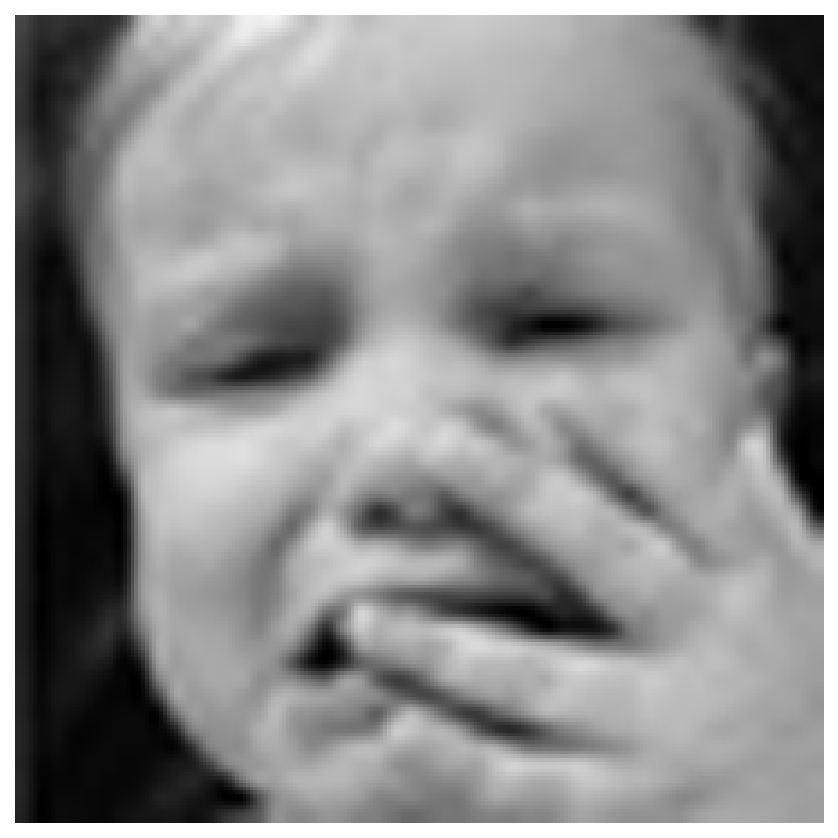

In [ ]:
showable_image = ((((sample +1)/2)* 255).numpy().clip(0, 255).astype(np.uint8)).transpose(1,2,0)

# mask_eyes = eyes_file[sample_id]['mask_eyes'][1] + eyes_file[sample_id]['mask_eyes'][0]
# mask_mouth = mouth_file[sample_id]['mask_mouth'][0]

eyes_tokens = eyes_indices[sample_id]
mouth_tokens = mouth_indices[sample_id]

patch_indices = image_patches[0] ## this list image_patches consists of identical elements for all images.
# print(patch_indices)
def pixel_mask_from_tokens(tokens):
    tokens_mask = np.zeros((224,224)).astype(bool)
    for token in tokens:
        left, upper, right, lower = patch_indices[token]
        for px in range(left,right):
            for py in range(upper,lower):
                tokens_mask[py,px] = True
    return tokens_mask
    
eyes_tokens_mask = []
for eye_tokens in eyes_tokens:
    eyes_tokens_mask.append(pixel_mask_from_tokens(eye_tokens))
mouth_token_mask = pixel_mask_from_tokens(mouth_tokens[0])
# print(patch_indices)
    
# mouth_shadow = np.ma.masked_where(mask_mouth==False, mask_mouth ) 
eyes_shadow = [np.ma.masked_where(eye_tokens_mask==False, eye_tokens_mask ) for eye_tokens_mask in eyes_tokens_mask]
mouth_shadow = np.ma.masked_where(mouth_token_mask==False, mouth_token_mask )

plt.figure(figsize=(7,7), dpi=150)
plt.imshow(showable_image)
# for eye_shadow in eyes_shadow:
#     plt.imshow(eye_shadow, alpha=.4)
# # print(eyes_shadow)
# plt.imshow(mouth_shadow,alpha=.4)
plt.axis('off')
plt.show()


In [ ]:
sample_id, dic['image'].replace('/home/farnoush/symbolicXAI/dataset/images/', 
                            '/Users/thomasschnake/Research/Projects/symbolic_xai/datasets/fer_images/')

(267,
 '/Users/thomasschnake/Research/Projects/symbolic_xai/datasets/fer_images/validation/happy/20685.jpg')

In [ ]:
from functools import reduce

target = torch.eye(7, dtype=sample.dtype)[label]
# target[0] = -1

symbxai_vit = ViTSymbolicXAI(
    model=model,
    embeddings=pretrained_embeddings,
    sample=sample.unsqueeze(0),
    target=target,
    start_subgraph_at=None
)

pred = model(sample.unsqueeze(0))['logits'].argmax()
print('prediction is:', [emotion for emotion,label in label_to_id.items() if label ==pred][0] )
# Only consider 'happy' and 'sad' classes.
if label in [0, 6] and sample_id not in problematic_images:
    total += 1
    if label == pred.item():
        # ids_dic[num] = sample_id
        num += 1
        
        eyes = [list(np.array( curr_eye_indices ).flatten() + 1) for curr_eye_indices in eyes_indices[sample_id]]
        
        mouth = list(np.array(mouth_indices[sample_id]).flatten() + 1) 
        rest = list(set(symbxai_vit.node_domain) - set(mouth) - set(reduce(lambda x,y: x+y, eyes)))
        
        not_mouth = list(set(symbxai_vit.node_domain) - set(mouth))
        not_eyes = list(set(symbxai_vit.node_domain) - set(reduce(lambda x,y: x+y, eyes)))
        not_rest = list(set(symbxai_vit.node_domain) - set(rest))
        

        table, subsets = generate_table(tokens)
        values = {}
        for subset in tqdm(subsets):
            tokens_subset = []
            if 'eyes' in subset:
                tokens_subset.append(reduce(lambda x,y: x+y, eyes))
            if 'mouth' in subset:
                tokens_subset.append(mouth)
            if 'rest' in subset:
                tokens_subset.append(rest)
            # rel = symbxai_vit.symb_and( tokens_subset, context=reduce(lambda x,y: x+y, tokens_subset ))
            rel = symbxai_vit.harsanyi_div(tokens_subset)
            values[subset] = rel
    else:
        print('label not target',  sample_id)
else:
    print('no, label or problematic image', sample_id)
        

prediction is: sad


100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


In [ ]:
set(mouth).intersection(reduce( lambda x,y: x+y,eyes))

set()

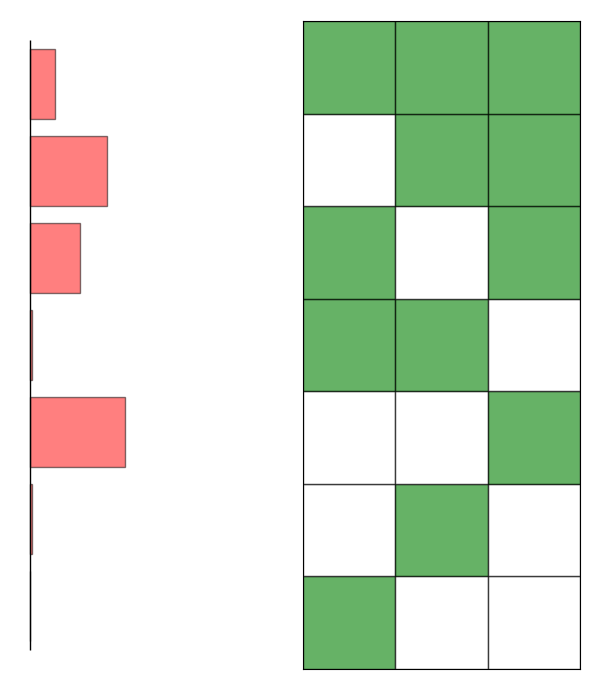

In [ ]:
from symbxai.visualization.utils import plot_table

# Example usage
# tokens = ['Not', 'very', 'good',]
# table, subsets = generate_table(interesting_tokens)
# values = {}
# for subset in tqdm(subsets):
#     values[subset] = explainer.harsanyi_div([tid for tid in subset])
# values  = data_rel_dic[0]
# values = {subset:  for subset in subsets }

plot_table(table, subsets, tokens, list(values.values()))

In [ ]:
values, sum(values.values())

({('eyes',): tensor(0.0157),
  ('mouth',): tensor(0.0534),
  ('rest',): tensor(2.4061),
  ('eyes', 'mouth'): tensor(0.0536),
  ('eyes', 'rest'): tensor(1.2580),
  ('mouth', 'rest'): tensor(1.9377),
  ('eyes', 'mouth', 'rest'): tensor(0.6431)},
 tensor(6.3675))